Крок 1: Імпорт бібліотек
python

In [3]:
# Імпорт необхідних бібліотек
import urllib.request
import pandas as pd
import os
from datetime import datetime
import hashlib
import re
import matplotlib.pyplot as plt
import seaborn as sns
print(f"Matplotlib версія: {matplotlib.__version__}")

ValueError: Key backend: 'module://matplotlib_inline.backend_inline' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

Крок 2: Завантаження даних з NOAA

In [ ]:
# Функція для завантаження даних VHI з NOAA
def download_vhi_data(region_id):
    """Завантажує дані VHI для області та зберігає у файлі з унікальним ім'ям."""
    url = f"https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?country=UKR&provinceID={region_id}&year1=1981&year2=2024&type=Mean"
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = os.path.join("data", f"vhi_{region_id}_{timestamp}.csv")

    try:
        response = urllib.request.urlopen(url)
        content = response.read()

        with open(output_file, 'wb') as file:
            file.write(content)

        print(f"Дані для області {region_id} завантажено у файл {output_file}")
        return output_file
    except Exception as e:
        print(f"Помилка при завантаженні даних для області {region_id}: {e}")
        return None

# Створення папки для збереження даних
if not os.path.exists("data"):
    os.makedirs("data")

# Завантаження даних для всіх областей
for region_id in range(1, 28):
    download_vhi_data(region_id)

Дані для області 1 завантажено у файл data\vhi_1_20250325_122427.csv
Дані для області 2 завантажено у файл data\vhi_2_20250325_122428.csv
Дані для області 3 завантажено у файл data\vhi_3_20250325_122430.csv
Дані для області 4 завантажено у файл data\vhi_4_20250325_122431.csv
Дані для області 5 завантажено у файл data\vhi_5_20250325_122432.csv
Дані для області 6 завантажено у файл data\vhi_6_20250325_122435.csv
Дані для області 7 завантажено у файл data\vhi_7_20250325_122436.csv
Дані для області 8 завантажено у файл data\vhi_8_20250325_122437.csv
Дані для області 9 завантажено у файл data\vhi_9_20250325_122439.csv
Дані для області 10 завантажено у файл data\vhi_10_20250325_122440.csv
Дані для області 11 завантажено у файл data\vhi_11_20250325_122443.csv
Дані для області 12 завантажено у файл data\vhi_12_20250325_122444.csv
Дані для області 13 завантажено у файл data\vhi_13_20250325_122445.csv
Дані для області 14 завантажено у файл data\vhi_14_20250325_122447.csv
Дані для області 15 зава

Крок 3: Читання та обробка даних

In [ ]:
# Функція для читання та обробки CSV-файлів
def process_csv_files(data_dir):
    """Читає CSV-файли з папки та об'єднує їх у один DataFrame."""
    all_data = pd.DataFrame()
    files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

    for file in files:
        file_path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(file_path, skiprows=2, names=["Year", "Week", "SMN", "SMT", "VCI", "TCI", "VHI", "empty"])
            df["Region_ID"] = int(re.findall(r'\d+', file)[0])  # Додаємо ID області
            all_data = pd.concat([all_data, df], ignore_index=True)
        except Exception as e:
            print(f"Помилка при читанні файлу {file}: {e}")

    # Видаляємо непотрібні стовпці та рядки з відсутніми даними
    all_data.drop(columns=["empty"], inplace=True)
    all_data.dropna(subset=["VHI"], inplace=True)

    # Очистка стовпця "Year" від HTML-тегів
    all_data['Year'] = all_data['Year'].apply(lambda x: re.sub(r'<[^>]+>', '', str(x)))
    all_data['Year'] = pd.to_numeric(all_data['Year'], errors='coerce')

    return all_data

# Обробка даних
data = process_csv_files("data")
print(data.head())

   Year  Week    SMN     SMT    VCI    TCI    VHI  Region_ID
0  1982   1.0  0.059  258.24  51.11  48.78  49.95         10
1  1982   2.0  0.063  261.53  55.89  38.20  47.04         10
2  1982   3.0  0.063  263.45  57.30  32.69  44.99         10
3  1982   4.0  0.061  265.10  53.96  28.62  41.29         10
4  1982   5.0  0.058  266.42  46.87  28.57  37.72         10


Крок 4: Зміна індексів областей

In [ ]:
# Словник для заміни індексів областей
region_mapping = {
    1: 24, 2: 26, 3: 25, 4: 27, 5: 3, 6: 4, 7: 8,
    8: 21, 9: 22, 10: 23, 11: 10, 12: 9, 13: 11, 14: 12,
    15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19,
    22: 20, 23: 6, 24: 1, 25: 2, 26: 7, 27: 5
}

# Функція для оновлення індексів областей
def update_region_ids(df, mapping):
    """Оновлює індекси областей у DataFrame."""
    df["Region_ID"] = df["Region_ID"].map(mapping)
    return df

# Оновлення індексів
data = update_region_ids(data, region_mapping)
print(data.head())

   Year  Week    SMN     SMT    VCI    TCI    VHI  Region_ID
0  1982   1.0  0.059  258.24  51.11  48.78  49.95         23
1  1982   2.0  0.063  261.53  55.89  38.20  47.04         23
2  1982   3.0  0.063  263.45  57.30  32.69  44.99         23
3  1982   4.0  0.061  265.10  53.96  28.62  41.29         23
4  1982   5.0  0.058  266.42  46.87  28.57  37.72         23


Крок 5: Аналіз даних
1. Отримати VHI для області за вказаний рік

In [ ]:
def get_vhi_by_region_year(df, region_id, year):
    """Повертає VHI для конкретної області за вказаний рік."""
    return df[(df["Region_ID"] == region_id) & (df["Year"] == year)][["Year", "Week", "VHI"]]

# Приклад використання
vhi_data = get_vhi_by_region_year(data, region_id=10, year=2020)
print(vhi_data)

       Year  Week    VHI
8687   2020   1.0  37.78
8688   2020   2.0  38.41
8689   2020   3.0  39.74
8690   2020   4.0  41.90
8691   2020   5.0  43.53
...     ...   ...    ...
13208  2020  48.0  37.69
13209  2020  49.0  38.98
13210  2020  50.0  40.16
13211  2020  51.0  38.82
13212  2020  52.0  38.73

[156 rows x 3 columns]


2. Пошук екстремумів (min, max), середнього, медіани

In [ ]:
def get_vhi_statistics(df, region_ids, years):
    """Повертає статистику VHI для вказаних областей та років."""
    filtered_df = df[(df["Region_ID"].isin(region_ids)) & (df["Year"].isin(years))]
    return filtered_df.groupby(["Region_ID", "Year"])["VHI"].agg(["min", "max", "mean", "median"]).reset_index()

# Приклад використання
stats = get_vhi_statistics(data, region_ids=[5, 10], years=[2000, 2020])
print(stats)

   Region_ID  Year    min    max       mean  median
0          5  2000  27.46  66.30  47.882885  47.375
1          5  2020  35.05  58.33  44.544231  43.660
2         10  2000  10.60  61.87  39.758269  35.915
3         10  2020  29.27  56.30  41.359423  39.375


3. Отримати VHI за вказаний діапазон років для вказаних областей

In [ ]:
def get_vhi_by_year_range(df, region_ids, start_year, end_year):
    """Повертає VHI за вказаний діапазон років для вказаних областей."""
    return df[(df["Region_ID"].isin(region_ids)) & (df["Year"].between(start_year, end_year))][["Year", "Week", "Region_ID", "VHI"]]

# Приклад використання
vhi_range_data = get_vhi_by_year_range(data, region_ids=[3, 7, 12], start_year=2010, end_year=2020)
print(vhi_range_data)

        Year  Week  Region_ID    VHI
28300   2010   1.0         12  49.52
28301   2010   2.0         12  47.62
28302   2010   3.0         12  47.81
28303   2010   4.0         12  46.64
28304   2010   5.0         12  45.57
...      ...   ...        ...    ...
154139  2020  48.0          3  42.12
154140  2020  49.0          3  43.01
154141  2020  50.0          3  43.61
154142  2020  51.0          3  44.95
154143  2020  52.0          3  47.12

[5148 rows x 4 columns]


4. Виявити роки з екстремальними посухами

In [ ]:
def find_drought_years(df, threshold=15, affected_percentage=0.2):
    """Повертає роки, коли посуха торкнулася більше вказаного відсотка областей."""
    province_count = df["Region_ID"].nunique()
    min_affected = int(province_count * affected_percentage)

    drought_data = df[df["VHI"] < threshold].groupby(["Year"])["Region_ID"].nunique().reset_index()
    drought_years = drought_data[drought_data["Region_ID"] >= min_affected]

    if drought_years.empty:
        print("Не знайдено років з екстремальними посухами.")
        return None

    return df[(df["Year"].isin(drought_years["Year"])) & (df["VHI"] < threshold)][["Year", "Region_ID", "VHI"]]

# Приклад використання
drought_info = find_drought_years(data)
print(drought_info)

        Year  Region_ID    VHI
153     1984         23  -1.00
154     1984         23  -1.00
155     1984         23  -1.00
156     1985         23  -1.00
157     1985         23  -1.00
...      ...        ...    ...
180288  2007         22  12.96
180289  2007         22  13.48
180290  2007         22  14.05
180291  2007         22  14.41
180292  2007         22  14.81

[4335 rows x 3 columns]


Крок 6: Візуалізація даних

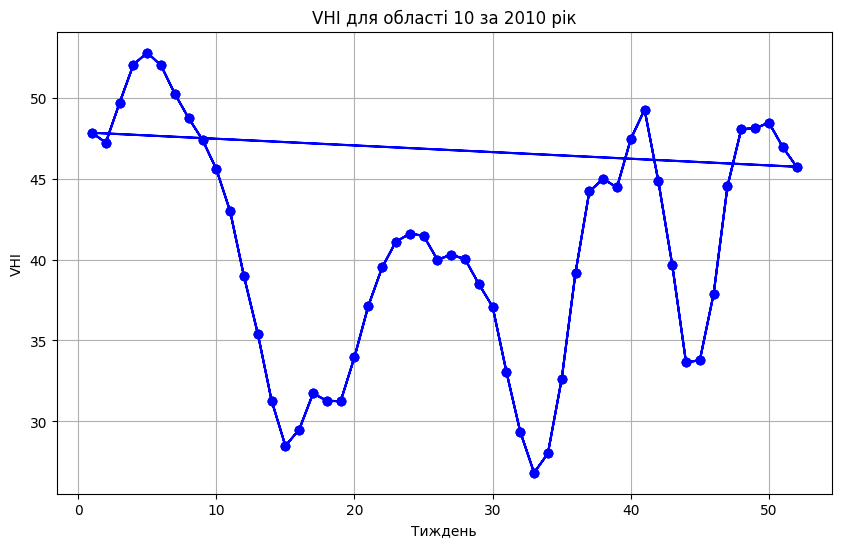

In [ ]:
# Побудова графіка VHI для області за рік
def plot_vhi_by_year(df, region_id, year):
    """Побудова графіка VHI для області за вказаний рік."""
    vhi_data = get_vhi_by_region_year(df, region_id, year)
    if vhi_data.empty:
        print(f"Немає даних для області {region_id} за {year} рік.")
        return
    plt.figure(figsize=(10, 6))
    plt.plot(vhi_data["Week"], vhi_data["VHI"], marker='o', linestyle='-', color='b')
    plt.title(f"VHI для області {region_id} за {year} рік")
    plt.xlabel("Тиждень")
    plt.ylabel("VHI")
    plt.grid(True)
    plt.show()

# Приклад використання
plot_vhi_by_year(data, region_id=10, year=2010)